# Metal Backend for Hardware Acceleration in Needle Framework



## Introduction
We have added a Metal backend to Needle framework to enable GPU acceleration for deep learning computations on M1 Mac. Metal is Apple's graphics framework that provides a low-level programming language called Metal Shading Language (MSL) for writing high-performance shaders and speeding up computations. By using the Metal backend, Needle framework can take advantage of the high-performance GPU on Apple devices and provide faster training speeds and higher performance for deep learning tasks.

At the same time, Needle framework also includes a high-level NN module library, which provides a set of neural network layers and components that can be easily combined to create complex model architectures. This library is designed to be flexible and modular, allowing users to easily experiment with different model configurations and architectures.

Overall, Needle framework is designed to provide users with a balance of low-level acceleration and high-level convenience, making it easy to build and train deep neural networks for a variety of tasks.

## Prepare the codebase

- Install dependencies:

In [3]:
!python3 -m pip install pybind11
!python3 -m pip install numpy

- Append Needle library:

In [2]:
import sys
sys.path.append('./python')

- Build array backend

In [4]:
!cmake . && make

-- The C compiler identification is AppleClang 14.0.0.14000029
-- The CXX compiler identification is AppleClang 14.0.0.14000029
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Python: /Users/amo/opt/anaconda3/bin/python3.9 (found version "3.9.12") found components: Development Interpreter Development.Module Development.Embed 
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- Performing Test HAS_FLTO_THIN
-- Performing Test HAS_FLTO_THIN - Success
-- F

## Metal Shading Language
Metal Shading Language (MSL) is a low-level programming language designed for use with Apple's Metal graphics framework. It is intended to provide developers with fine-grained control over the rendering pipeline, allowing for the creation of highly optimized and performant shaders on M1 chips and other Apple devices.

Based on the C++ programming language, MSL offers a set of built-in functions and data types for graphics and compute tasks, as well as language extensions specific to Metal, such as support for vertex, fragment, and compute shaders, and resource and memory management.

### Metal command queue
In the Metal architecture, the `MTLDevice` protocol supports methods for encoding and queueing render and compute commands to be submitted to the GPU for execution.

A command queue consists of a queue of command buffers, and a command queue organizes the order of execution of those command buffers. A command buffer contains encoded commands that are intended for execution on a particular device. A command encoder appends rendering, computing, and blitting commands onto a command buffer, and those command buffers are eventually committed for execution on the device.

The `MTLCommandQueue` protocol defines an interface for command queues, primarily supporting methods for creating command buffer objects. The `MTLCommandBuffer` protocol defines an interface for command buffers and provides methods for creating command encoders, enqueueing command buffers for execution, checking status, and other operations.

![](https://developer.apple.com/library/archive/documentation/Miscellaneous/Conceptual/MetalProgrammingGuide/Art/Cmd-Model-1_2x.png)

We have abstracted a class called `MyMetal` to organize the command queue and submit command buffers to the GPU. This class provides useful methods including `LoadKernelsFromFile` to load kernel command from `.metal` files, `RegisterKernel` on `MTLDevice`, `GetComputePipelineState` for create command buffer, etc. 
Then we create macros for command encoder to reduce the number of lines of code, which makes the implementation of the array operators more readable.

``` cpp
#define BEGIN_COMPUTE_COMMAND(command_kernel_name)                             \
  MyMetal* metal = MyMetal::GetInstance();                                     \
  MTL::CommandBuffer* command_buffer =                                         \
      metal->command_queue()->commandBuffer();                                 \
  MTL::ComputeCommandEncoder* command_encoder =                                \
      command_buffer->computeCommandEncoder();                                 \
  command_encoder->setComputePipelineState(                                    \
      metal->GetComputePipelineState(command_kernel_name));

#define END_COMPUTE_COMMAND                                                    \
  command_encoder->endEncoding();                                              \
  command_buffer->commit();                                                    \
  command_buffer->waitUntilCompleted();                                        \
  command_encoder->release();                                                  \
  command_buffer->release();

```

### Build Metal library 
One major difference between the compile process for Cuda and Metal is the support for the g++ compiler. Cuda code can be compiled using the g++ compiler as well as the NVCC compiler provided as part of the Cuda Toolkit. This allows Cuda code to be integrated into a wider range of build systems and development environments.

However, Metal code is not supported by the g++ compiler and must be compiled using the Xcode build tools. This processes can also be done Without using Xcode by integrating the command line utilities into `CMakeLists.txt`. 

``` bash
xcrun -sdk macosx metal src/metal/kernels.metal -c -o kernels.air
xcrun -sdk macosx metallib kernels.air -o kernels.metallib
```

As the image shown below, first compile `.metal` files into a single `.air` file, which stores an intermediate representation (IR) of shader language code. Then we use the `metallib` tool to build a Metal `.metallib` library file from IR `.air` files


![](https://developer.apple.com/library/archive/documentation/Miscellaneous/Conceptual/MetalProgrammingGuide/Art/library_2x.png)

## Multi-level Operators 
Take tanh activation function for example, in this pipeline we have actually implement 4 levels of abstraction.

### nn.py
From NN Module, we have Tanh activation layer. This layer calls tanh from ops.

``` python
class Tanh(Module):
    def forward(self, x: Tensor) -> Tensor:
        return ops.tanh(x)
```
### ops.py
In ops, it calls low-level array api to compute the tanh.
``` python
class Tanh(TensorOp):
    def compute(self, a):
        return array_api.tanh(a)

    def gradient(self, out_grad, node):
        tmp = exp(node.inputs[0] * 2)
        return ((tmp + 2 + tmp ** -1) ** -1 * 4 * out_grad,)


def tanh(a):
    return Tanh()(a)
```

### ndarray_backend_metal.cc
The cpp interface of Metal register the kernel from `.metal` file and then encode command to make command buffer ready for execution.
``` cpp
void EwiseTanh(const MetalArray<scalar_t>& a, MetalArray<scalar_t>* out) {
  BEGIN_COMPUTE_COMMAND("EwiseTanhKernel")

  command_encoder->setBuffer(a.buffer, 0, 0);
  command_encoder->setBuffer(out->buffer, 0, 1);
  MetalDims dim = MetalOneDim(a.size);
  command_encoder->dispatchThreads(dim.num_threads_per_grid, dim.num_threads_per_group);

  END_COMPUTE_COMMAND
}
```

### kernels.metal
In kernel command, it finally calls Tanh from Metal api.
``` glsl
kernel void EwiseTanhKernel(device const float* a [[buffer(0)]],
                            device float* out [[buffer(1)]],
                            uint index [[thread_position_in_grid]]) {
  float tmp = metal::tanh(a[index]);
  out[index] = metal::isnan(tmp) ? 1.0: tmp;
}
```


## Results

Based on the assignments and lectures, we implemented a small GAN for testing framework performance using the Metal backend. 

### Simple GAN from lecture

#### Generate Data

In [5]:
import needle as ndl
import numpy as np
from needle import nn
from matplotlib import pyplot as plt

In [53]:
A = np.array([[1, 2], [-0.2, 0.5]])
mu = np.array([2, 1])
# total number of sample data to generated
num_sample = 3200
data = np.random.normal(0, 1, (num_sample, 2)) @ A + mu

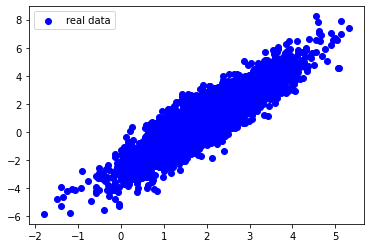

In [54]:
plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.legend()

In [55]:
def sample_G(model_G, num_samples):
    Z = ndl.Tensor(np.random.normal(0, 1, (num_samples, 2)), device=device)
    fake_X = model_G(Z)
    return fake_X.numpy()

#### GAN Loss and GAN Model

In [56]:
class GANLoss:
    def __init__(self, model_D, opt_D, device=None, dtype='float32'):
        self.device = device
        self.dtype = dtype
        self.model_D = model_D
        self.opt_D = opt_D
        self.loss_D = nn.SoftmaxLoss()

    def _update_D(self, real_X, fake_X):
        real_Y = self.model_D(real_X)
        fake_Y = self.model_D(fake_X.detach())
        batch_size = real_X.shape[0]
        ones = ndl.ones(batch_size, device=self.device, dtype=self.dtype)
        zeros = ndl.zeros(batch_size, device=self.device, dtype=self.dtype)
        loss = self.loss_D(real_Y, ones) + self.loss_D(fake_Y, zeros)
        loss.backward()
        self.opt_D.step()

    def forward(self, fake_X, real_X):
        self._update_D(real_X, fake_X)
        fake_Y = self.model_D(fake_X)
        batch_size = real_X.shape[0]
        ones = ndl.ones(batch_size, device=self.device, dtype=self.dtype)
        loss = self.loss_D(fake_Y, ones)
        return loss

In [59]:
device = ndl.metal()

model_G = nn.Sequential(nn.Linear(2, 2, device=device))
opt_G = ndl.optim.Adam(model_G.parameters(), lr = 0.01)

model_D = nn.Sequential(
    nn.Linear(2, 20, device=device),
    nn.ReLU(),
    nn.Linear(20, 10, device=device),
    nn.ReLU(),
    nn.Linear(10, 2, device=device)
)
opt_D = ndl.optim.Adam(model_D.parameters(), lr=0.01)
gan_loss = GANLoss(model_D, opt_D, device=device)

fake_data_init = sample_G(model_G, 3200)

#### Training process and results

In [60]:
def train_gan(data, batch_size, num_epochs):
    assert data.shape[0] % batch_size == 0
    for epoch in range(num_epochs):
        begin = (batch_size * epoch) % data.shape[0]
        X = data[begin: begin+batch_size, :]
        Z = np.random.normal(0, 1, (batch_size, 2))
        X = ndl.Tensor(X, device=device)
        Z = ndl.Tensor(Z, device=device)
        fake_X = model_G(Z)
        loss = gan_loss.forward(fake_X, X)
        loss.backward()
        opt_G.step()

train_gan(data, 32, 2000)

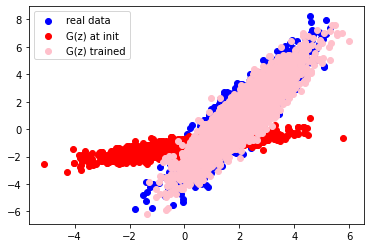

In [61]:
fake_data_trained = sample_G(model_G, 3200)

plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.scatter(fake_data_init[:,0], fake_data_init[:,1], color="red", label="G(z) at init")
plt.scatter(fake_data_trained[:,0], fake_data_trained[:,1], color="pink", label="G(z) trained")

plt.legend()

## Conclusion
In our project, we added a Metal backend to the Needle framework. We have completed all of the test cases from mugrade grading system and received full score from all assignments. However, we have noticed that the performance of the Metal backend is a little bit slower compared to other acceleration backends.

In order to further improve the performance of the Metal backend, it may be necessary to optimize the code and the configuration of the Metal pipeline, as well as to explore other possible performance improvements within the Needle framework. Further optimization and testing may be necessary to fully realize the potential of the Metal backend for hardware acceleration.